# Training an image classification model using the FastAI library
This is part 2 of a presentation I gave for ML Squamish. The aim of the presentation was to get beginners from no-code to training their own image recognition model in a 2 hour workshop. 

At this stage we'd just got everyone set up on a virtual machine using Paperspace Gradient, and people had their first notebook instances open. 


## Most of this notebook is adapted from the fast.ai course material, [link here](https://github.com/fastai/fastbook/blob/master/02_production.ipynb)
### Notebook Tips
- type ? or ?? next to a function then __shift + return__ to execute the cell to get the source code. 
- Press shift + tab inside function's parentheses to get function signature and docstring
- Type the name of a module and hit enter to get info about its type and location. 

# Install required libraries

In [19]:
!pip install -Uqq fastai
!pip install duckduckgo_search

# Imports

In [97]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastdownload import download_url
import torch
from duckduckgo_search import ddg_images


In [83]:
import warnings
warnings.filterwarnings('ignore')

In [84]:
def search_images(term, max_images = 200):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [85]:
search_images('canoe')[0]

'https://northernwilds.com/wp-content/uploads/2018/06/IMG_1530_opt.jpeg'

In [86]:
ims = search_images('canoe')

In [6]:
dest = ('images/canoe.jpg')
download_url(ims[0], dest)

Path('images/canoe.jpg')

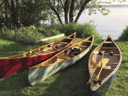

In [7]:
im = Image.open(dest)
im.to_thumb(128, 128)

## Change your code to reflect the categories you're using. 

In [47]:
boat_types = 'canoe', 'kayak', 'sailboat'

In [48]:
path = Path('boats')

Download images from chosen categories. 

This cell may take a few minutes to run

In [10]:
if not path.exists():
    path.mkdir()
    for boat in boat_types:
        dest = (path/boat)
        dest.mkdir(exist_ok=True)
        results = search_images(boat)
        download_images(dest, urls=results)

In [11]:
!ls {path}
path

canoe  kayak  sailboat


Path('boats')

In [12]:
filenames = get_image_files(path)
filenames

(#554) [Path('boats/sailboat/3b873c96-0d1f-4404-9aae-af25d3805177.jpg'),Path('boats/sailboat/6336c57d-8ad9-4318-836c-fba58b5357be.jpg'),Path('boats/sailboat/d2a981d0-0d3e-4b0e-a077-a5cbda1a41b0.JPG'),Path('boats/sailboat/da7dc60e-7c83-4807-9fc1-a0f5061a5080.jpg'),Path('boats/sailboat/168643af-803b-4783-8c6b-a785157c481e.jpeg'),Path('boats/sailboat/f4055206-199c-42a8-bf74-8ed6c4dc7e08.jpg'),Path('boats/sailboat/d5883260-5325-41cb-a645-016051c37819.jpg'),Path('boats/sailboat/4b44e5d8-75e1-413b-a9b9-bd3f19b63df4.jpg'),Path('boats/sailboat/86d8f1b9-b75b-467f-8476-2d91805a150b.jpg'),Path('boats/sailboat/e07b4c1d-a717-4c10-9059-005016798081.jpeg')...]

In [13]:
failed = verify_images(filenames)

In [14]:
failed

(#0) []

In [15]:
failed.map(Path.unlink)

(#0) []

In [16]:
failed

(#0) []

## Create a way to load datasets and dataloaders

In [24]:
boats = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [25]:
dataloaders = boats.dataloaders(path)

In [51]:
dataloaders.device

device(type='cuda', index=0)

If the device type is 'cuda' that means we've got the model on the GPU. If device type is 'cpu' then now's a good time to see if there is a free GPU instance available. The data you downloaded earlier won't be lost since Paperspace has persistent storage. 

In [146]:
# Docs for some modules. Uncomment as required. 
# DataLoader?
# DataLoaders?
# Datasets?
# torch.utils.data.Dataset?
# torch.utils.data.DataLoader?

## Training and validation sets

Our data is split into training and validation batches. 20% of the data is in the validation set, and 80% is in the training set. 

__Dataset__: an iterable over tuples containing images with their corresponding category. <br>
__DataLoader__: a PyTorch iterable returning a batch of datasets.<br> 
__DataLoaders__: a fastai iterable which splits dataloaders into training and validation datasets. 

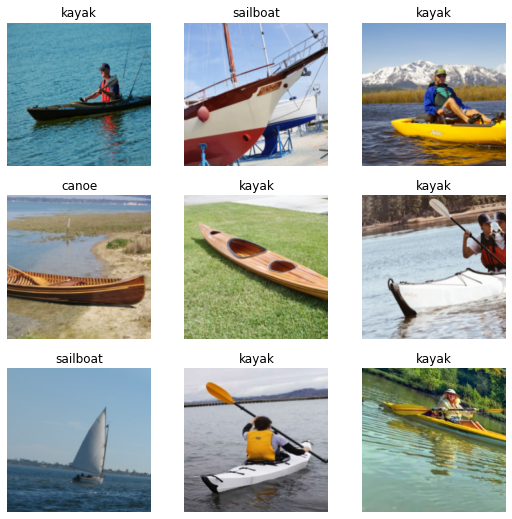

In [147]:
dataloaders.train.show_batch()

# Item transformations

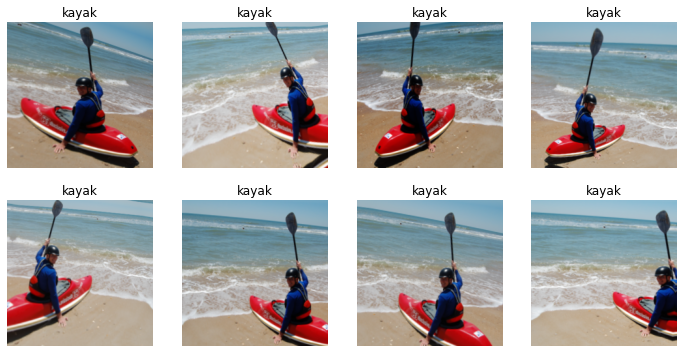

In [79]:
boats = boats.new(RandomResizedCrop(224, min_scale=0.5), 
                  batch_tfms=aug_transforms())
dataloaders = boats.dataloaders(path)
dataloaders.train.show_batch(max_n=8, nrows=2, unique=True)

## Train a model

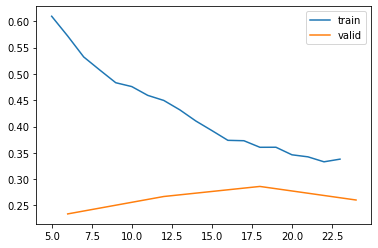

In [159]:
learn = vision_learner(dataloaders, resnet18, metrics=error_rate)
learn.fine_tune(4)
learn.recorder.plot_loss()

# Confusion matrix

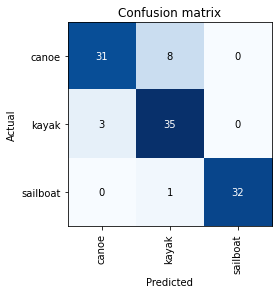

In [160]:
interpreter = ClassificationInterpretation.from_learner(learn)
interpreter.plot_confusion_matrix()

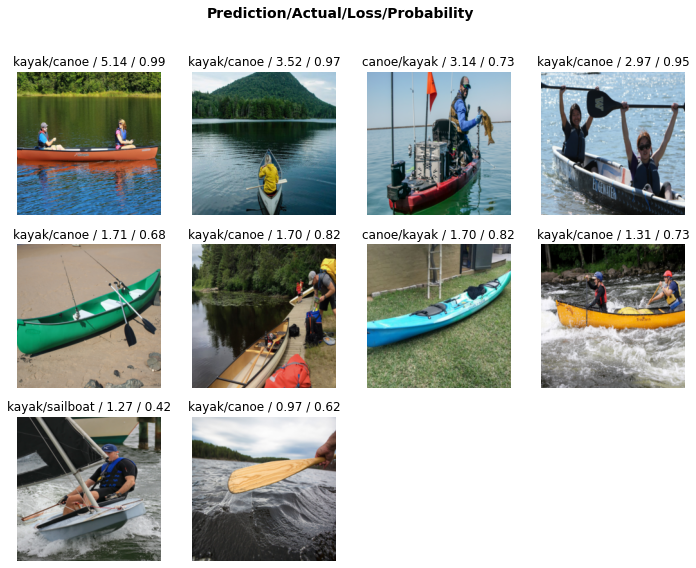

In [161]:
interpreter.plot_top_losses(10)

In [152]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [156]:
# Delete bad images
for idx in cleaner.delete(): 
    cleaner.fns[idx].unlink()
    
# Recategorize mislabelled images
for idx, cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)

# Re train model with better data

SuggestedLRs(valley=0.00010964782268274575)

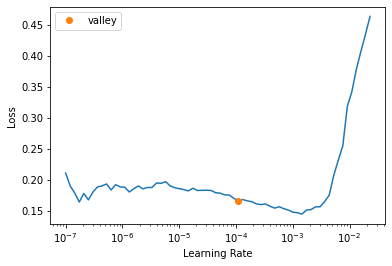

In [162]:
learn.lr_find()

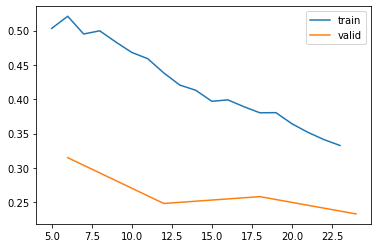

In [163]:
learn = vision_learner(dataloaders, resnet18, metrics=error_rate, lr=1e-4)
learn.fine_tune(4)
learn.recorder.plot_loss()

# Use the model to predict on unseen data.
Upload some images to the images folder of your GPU instance. Make sure the images weren't in the training set.  
See how well your model does at differentiating between different images. 
I've uploaded some of my own photos to test. 

In [177]:
!ls images

canoe.jpg      testboat2.JPG  testboat4.JPG  testboat6.JPG  testboat8.JPG
testboat1.JPG  testboat3.JPG  testboat5.JPG  testboat7.JPG  testboat9.JPG


In [178]:
prediction, index, probs = learn.predict('images/testboat1.JPG')

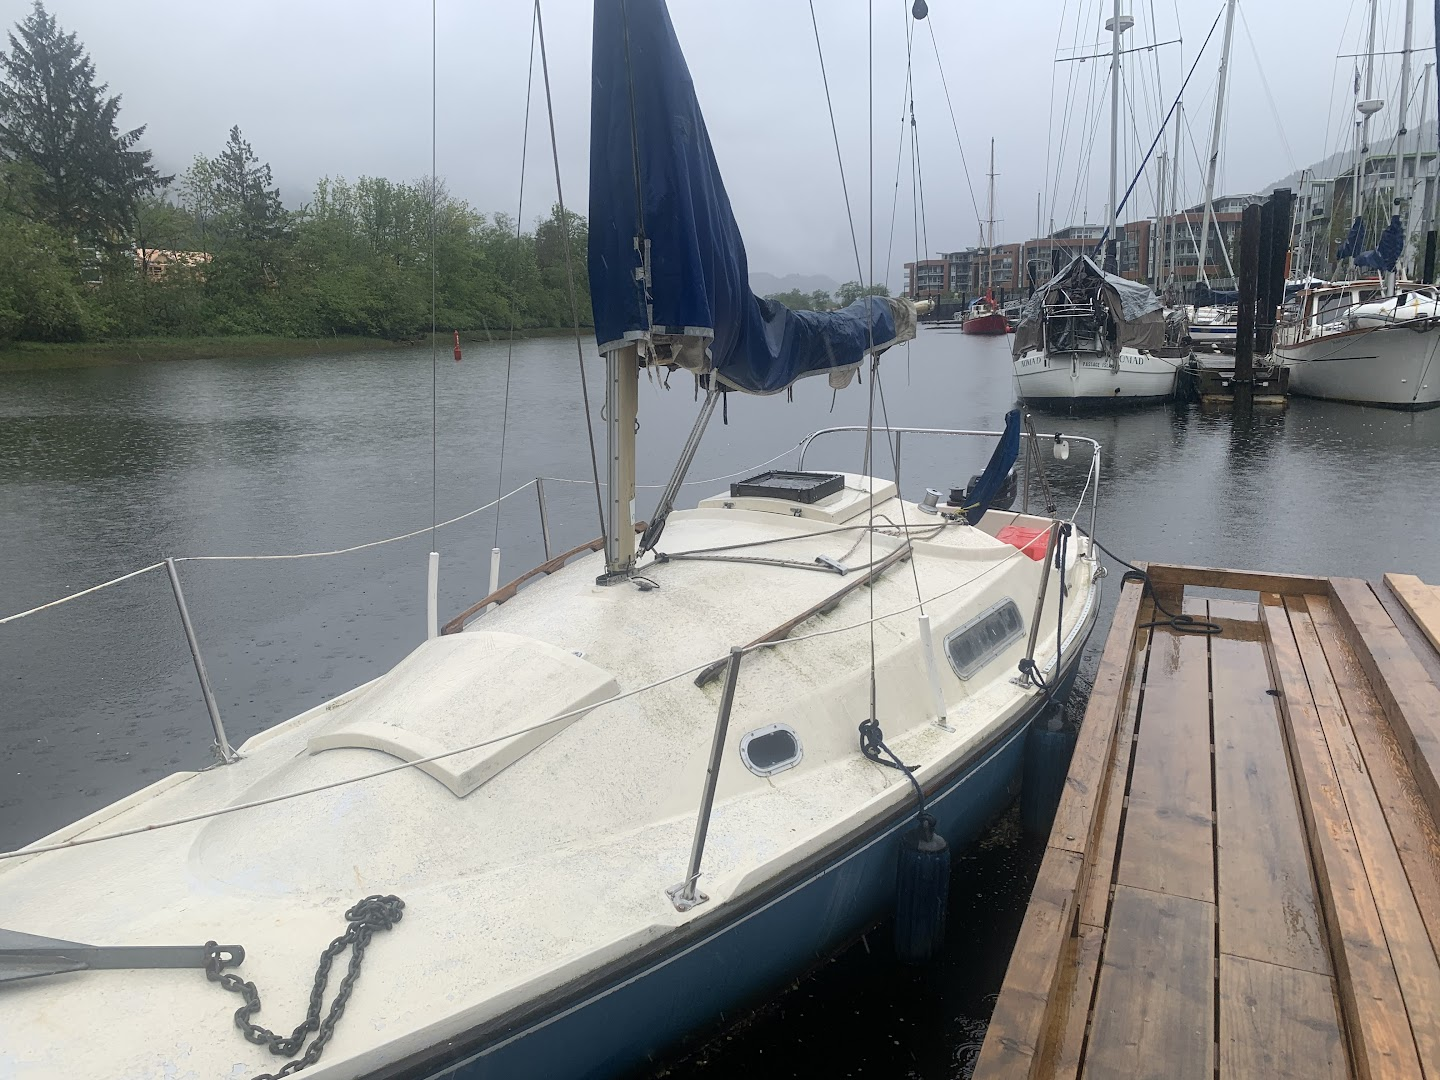

In [179]:
Image.open('images/testboat1.JPG')

In [180]:
print(f"The model predicted {prediction} with a confidence of {probs[index]}")

The model predicted sailboat with a confidence of 0.9995493292808533


# That's pretty good! Let's have a discussion about the results.